In [ ]:
# this model uses deep learning to perform multiclass classification of clothing items

# data source: https://github.com/zalandoresearch/fashion-mnist

'''
Context
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples
and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from
10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST
dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training
and testing splits.

Labels

Each training and test example is assigned to one of the following labels:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

Analysis steps:
  1. Load data
  2. Visualize sample images
  3. Split/shape data into train/validation/test sets, normalize data and one-hot encode labels
  4. Set up deep learning model using Keras
  5. Run model and find loss/accuracy
  6. Plot training history
'''

In [95]:
import numpy as np
import pandas as pd

import keras

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, InputLayer
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [8]:
# load training and test data
data_train = pd.read_csv('fashion-mnist_train.csv')
data_test = pd.read_csv('fashion-mnist_test.csv')

data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


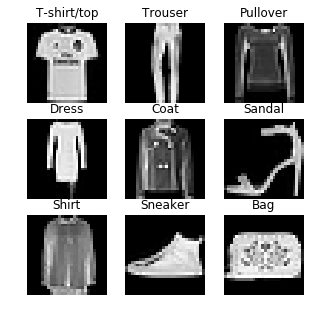

In [175]:
# visualize sample of each clothing type from dataset

# create dictionary using [item index] = item name
item_dict = {0 : 'T-shirt/top',
             1 : 'Trouser',
             2 : 'Pullover',
             3 : 'Dress',
             4 : 'Coat',
             5 : 'Sandal',
             6 : 'Shirt',
             7 : 'Sneaker',
             8 : 'Bag',
             9 : 'Ankle boot'}

rows = 3
cols = 3

f, ax = plt.subplots(rows, cols, figsize = (5,5))
count = 0

for row in range(rows):
    for col in range(cols):

        i = np.where(data_test.values[:,0] == count)[0][0]
        img = data_test.iloc[i,1:].values.reshape(28,28)

        ax[row,col].imshow(img, cmap='gray')
        ax[row,col].set_title(item_dict[count])
        axoff = ax[row,col].axis('off')
        
        count += 1

In [36]:
# separate the data and labels
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])

X_test = np.array(data_test.iloc[:,1:])
y_test = np.array(data_test.iloc[:,0])

# convert the X-data to float and then scale values in [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert labels to categorical values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
# reshape images from 784 length flat array to 28x28x1 array (no color)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [74]:
# split X_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [84]:
# build model (roughly following pg 141 of "Deep Learning with Python" by Francois Chollet, though mine has a softmax output)

# Notes from several model variants (90% accuracy for most attempts):
# 1. first run had dropout of 0.5 only after Flatten()
# 2. first run stalled at 0.8974 val_acc after 17 epochs; try adding small dropout (0.25) after each MaxPooling2D and Dense layers to help with overfitting
# 3. next model in (2) peaked at 0.89 after 11 epochs
# 4. remove all dropout except before flatten (0.4) and try different kernel_initializer in first layer (he_normal)
# 5. stalling at 0.896 after 10 epoch; seems to be overfitting, so add dropout of 0.4 between Dense layers


numClasses = 10

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(numClasses, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 1, 128)         0         
__________

In [86]:
# model training

batch_size = 16
epochs = 30

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 78s 2ms/step - loss: 0.6952 - acc: 0.7475 - val_loss: 0.4392 - val_acc: 0.8393
Epoch 2/30
48000/48000 [==============================] - 72s 1ms/step - loss: 0.4772 - acc: 0.8285 - val_loss: 0.3824 - val_acc: 0.8597
Epoch 3/30
48000/48000 [==============================] - 83s 2ms/step - loss: 0.4183 - acc: 0.8494 - val_loss: 0.3617 - val_acc: 0.8623
Epoch 4/30
48000/48000 [==============================] - 72s 1ms/step - loss: 0.3853 - acc: 0.8621 - val_loss: 0.3355 - val_acc: 0.8730
Epoch 5/30
48000/48000 [==============================] - 71s 1ms/step - loss: 0.3641 - acc: 0.8696 - val_loss: 0.3209 - val_acc: 0.8791
Epoch 6/30
48000/48000 [==============================] - 74s 2ms/step - loss: 0.3441 - acc: 0.8773 - val_loss: 0.3076 - val_acc: 0.8838
Epoch 7/30
48000/48000 [==============================] - 75s 2ms/step - loss: 0.3280 - acc: 0.8823 - val_loss: 0.3173 - val_acc

In [92]:
print('Model performance on test data')
print('    loss : {:.4f}'.format(score[0]))
print('accuracy : {:.4f}'.format(score[1]))

Model performance on test data
    loss : 0.3126
accuracy : 0.8983


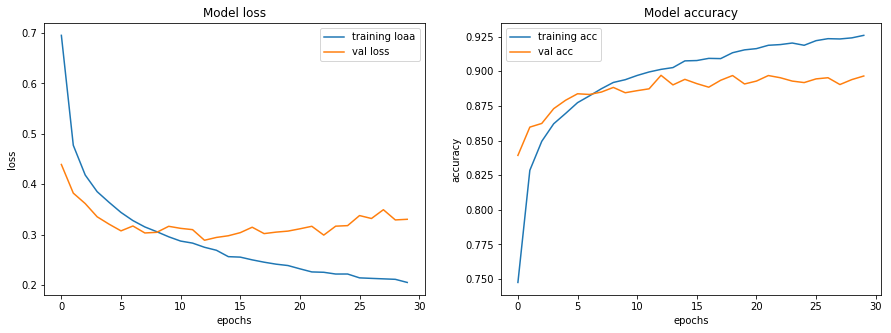

In [173]:
# plot training and validation loss and accuracy vs. epochs

# set up values
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

# set up figure
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,5))

# loss plot
ax1.plot(train_loss, label='training loaa')
ax1.plot(val_loss, label='val loss')
ax1.set_title('Model loss')
ax1.set(xlabel='epochs', ylabel='loss')
ax1.legend()

# accuracy plot
ax2.plot(train_acc, label='training acc')
ax2.plot(val_acc, label='val acc')
ax2.set_title('Model accuracy')
ax2.set(xlabel='epochs', ylabel='accuracy')
ax2.legend()